In [5]:
!pip install pyspark

In [37]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor as SparkRandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [9]:
from google.colab import files
uploaded = files.upload()

Saving forestfires.csv to forestfires.csv


In [11]:
# Initialize Spark session
spark = SparkSession.builder.appName("WildfirePrediction").master("local[4]").getOrCreate()

In [12]:
# Q2: Data Ingestion
start_time = time.time()
data = spark.read.csv("/content/forestfires.csv", header=True, inferSchema=True)
spark_load_time = time.time() - start_time

In [15]:
# Q2 & Q3: Preprocessing with Spark (Parallel)
start_time = time.time()
from pyspark.sql.functions import log1p
data = data.withColumn("log_area", log1p(data["area"]))
spark_preprocess_time = time.time() - start_time

In [16]:
# Q3: Preprocessing with Pandas (Single-Core)
start_time = time.time()
pandas_data = pd.read_csv("/content/forestfires.csv")
pandas_data = pd.get_dummies(pandas_data, columns=["month", "day"])
pandas_preprocess_time = time.time() - start_time

In [20]:
# Split data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
# Use the pandas_data dataframe for sklearn models as it's already preprocessed with get_dummies
X = pandas_data.drop("area", axis=1) # Assuming 'area' is the target variable
y = np.log1p(pandas_data["area"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Q2 & Q3: Linear Regression (Spark)
start_time = time.time()
lr = LinearRegression(featuresCol="scaled_features", labelCol="log_area")
lr_model = lr.fit(train_data)
spark_lr_train_time = time.time() - start_time

In [21]:
# Q3: Linear Regression (sklearn, Single-Core)
start_time = time.time()
sklearn_lr = SklearnLinearRegression()
sklearn_lr.fit(X_train, y_train)
sklearn_lr_train_time = time.time() - start_time

In [22]:
# Q2 & Q3: Random Forest (sklearn, Parallel)
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
rf_parallel_train_time = time.time() - start_time

In [23]:
# Q3: Random Forest (sklearn, Single-Core)
start_time = time.time()
rf_model_single = RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=42)
rf_model_single.fit(X_train, y_train)
rf_single_train_time = time.time() - start_time

In [24]:
# Q3: Random Forest (Spark)
start_time = time.time()
spark_rf = SparkRandomForest(featuresCol="scaled_features", labelCol="log_area", numTrees=100, seed=42)
spark_rf_model = spark_rf.fit(train_data)
spark_rf_train_time = time.time() - start_time

In [26]:
# Q2, Q3, Q5: Evaluation
from pyspark.sql.functions import expm1

lr_predictions = lr_model.transform(test_data)
lr_predictions = lr_predictions.withColumn("prediction", expm1(lr_predictions["prediction"]))
lr_predictions = lr_predictions.withColumn("area", expm1(lr_predictions["log_area"]))
lr_pandas = lr_predictions.select("area", "prediction").toPandas()
lr_mae = mean_absolute_error(lr_pandas["area"], lr_pandas["prediction"])
lr_rmse = np.sqrt(mean_squared_error(lr_pandas["area"], lr_pandas["prediction"]))

sklearn_lr_predictions = np.expm1(sklearn_lr.predict(X_test))
rf_predictions = np.expm1(rf_model.predict(X_test))
sklearn_lr_mae = mean_absolute_error(np.expm1(y_test), sklearn_lr_predictions)
sklearn_lr_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), sklearn_lr_predictions))
rf_mae = mean_absolute_error(np.expm1(y_test), rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), rf_predictions))

spark_rf_predictions = spark_rf_model.transform(test_data)
spark_rf_predictions = spark_rf_predictions.withColumn("prediction", expm1(spark_rf_predictions["prediction"]))
spark_rf_predictions = spark_rf_predictions.withColumn("area", expm1(spark_rf_predictions["log_area"]))
spark_rf_pandas = spark_rf_predictions.select("area", "prediction").toPandas()
spark_rf_mae = mean_absolute_error(spark_rf_pandas["area"], spark_rf_pandas["prediction"])
spark_rf_rmse = np.sqrt(mean_squared_error(spark_rf_pandas["area"], spark_rf_pandas["prediction"]))

In [27]:
# Q5: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

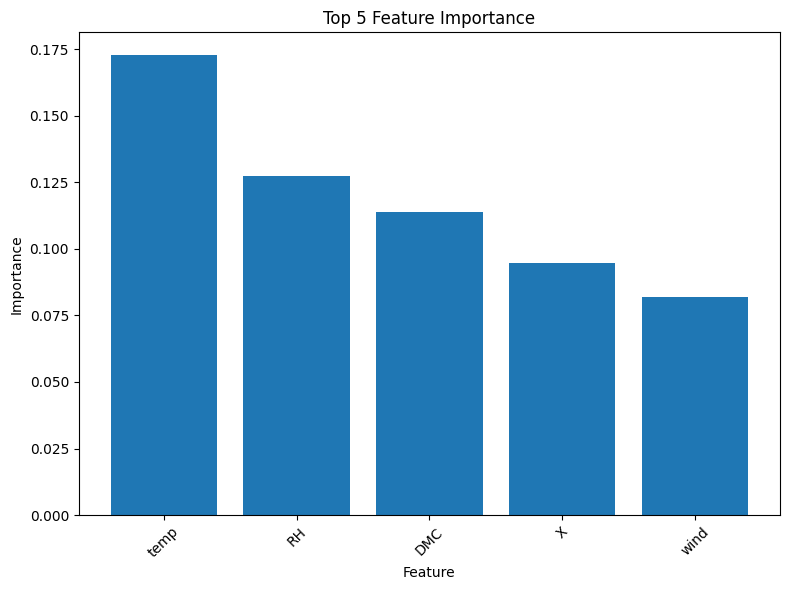

In [28]:
# Q5: Visualization
plt.figure(figsize=(8, 6))
plt.bar(feature_importance['feature'][:5], feature_importance['importance'][:5])
plt.title('Top 5 Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

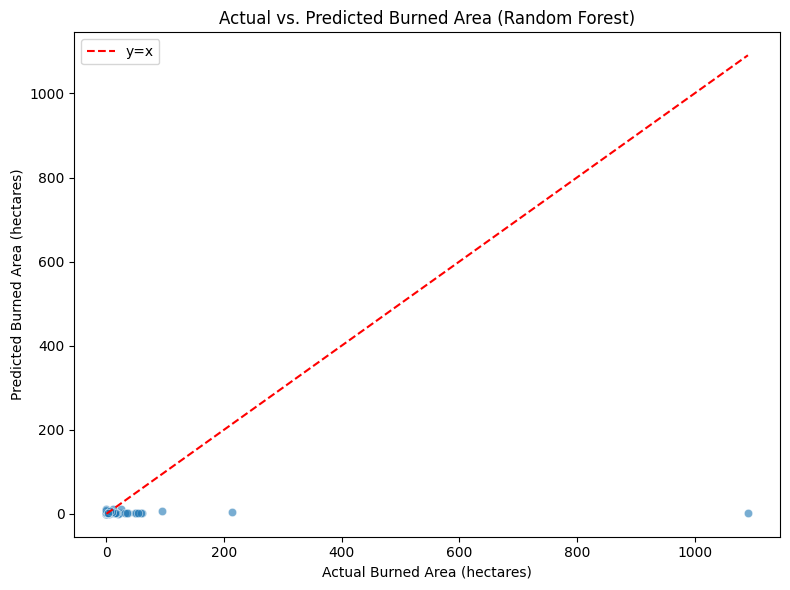

In [38]:
# Scatter plot for Random Forest regression results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.expm1(y_test), y=rf_predictions, alpha=0.6)
plt.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--', label='y=x')
plt.title("Actual vs. Predicted Burned Area (Random Forest)")
plt.xlabel("Actual Burned Area (hectares)")
plt.ylabel("Predicted Burned Area (hectares)")
plt.legend()
plt.tight_layout()
plt.savefig("scatter_plot.png")
plt.show()

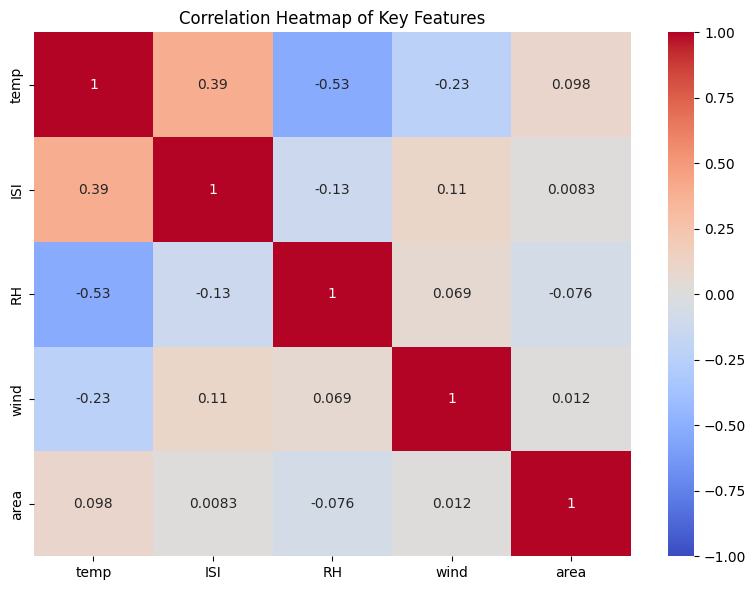

In [39]:
# Heatmap for correlation of key features
key_features = ["temp", "ISI", "RH", "wind", "area"]
corr_matrix = pandas_data[key_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Key Features")
plt.tight_layout()
plt.savefig("heatmap.png")
plt.show()

In [40]:
# Print results
print(f"Q2 - Spark Data Load Time: {spark_load_time:.2f}s")
print(f"Q2 - Spark Linear Regression Train Time: {spark_lr_train_time:.2f}s")
print(f"Q2 - Random Forest Train Time (multiprocessing): {rf_parallel_train_time:.2f}s")
print(f"Q2 - Linear Regression MAE: {lr_mae:.2f} hectares")
print(f"Q2 - Linear Regression RMSE: {lr_rmse:.2f} hectares")
print(f"Q2 - Random Forest MAE: {rf_mae:.2f} hectares")
print(f"Q2 - Random Forest RMSE: {rf_rmse:.2f} hectares")
print(f"Q2 - Random Forest Top Features:\n{feature_importance.head()}")
print(f"Q3 - Preprocessing Time (Spark, Parallel): {spark_preprocess_time:.2f}s")
print(f"Q3 - Preprocessing Time (Pandas, Single-Core): {pandas_preprocess_time:.2f}s")
print(f"Q3 - Linear Regression Train Time (Spark, Parallel): {spark_lr_train_time:.2f}s")
print(f"Q3 - Linear Regression Train Time (sklearn, Single-Core): {sklearn_lr_train_time:.2f}s")
print(f"Q3 - Random Forest Train Time (sklearn, Parallel): {rf_parallel_train_time:.2f}s")
print(f"Q3 - Random Forest Train Time (sklearn, Single-Core): {rf_single_train_time:.2f}s")
print(f"Q3 - Random Forest Train Time (Spark, Parallel): {spark_rf_train_time:.2f}s")
print(f"Q3 - Linear Regression MAE (Spark): {lr_mae:.2f} hectares")
print(f"Q3 - Linear Regression RMSE (Spark): {lr_rmse:.2f} hectares")
print(f"Q3 - Linear Regression MAE (sklearn): {sklearn_lr_mae:.2f} hectares")
print(f"Q3 - Linear Regression RMSE (sklearn): {sklearn_lr_rmse:.2f} hectares")
print(f"Q3 - Random Forest MAE (sklearn): {rf_mae:.2f} hectares")
print(f"Q3 - Random Forest RMSE (sklearn): {rf_rmse:.2f} hectares")
print(f"Q3 - Random Forest MAE (Spark): {spark_rf_mae:.2f} hectares")
print(f"Q3 - Random Forest RMSE (Spark): {spark_rf_rmse:.2f} hectares")
print(f"Q3 - Random Forest Top Features:\n{feature_importance.head()}")
print(f"Q5 - Model Evaluation Summary:")
print(f"Q5 - Linear Regression MAE: {lr_mae:.2f} hectares, RMSE: {lr_rmse:.2f} hectares")
print(f"Q5 - Random Forest MAE: {rf_mae:.2f} hectares, RMSE: {rf_rmse:.2f} hectares")
print(f"Q5 - Random Forest (Spark) MAE: {spark_rf_mae:.2f} hectares, RMSE: {spark_rf_rmse:.2f} hectares")
print(f"Q5 - Top Features:\n{feature_importance.head()}")

Q2 - Spark Data Load Time: 7.30s
Q2 - Spark Linear Regression Train Time: 3.24s
Q2 - Random Forest Train Time (multiprocessing): 1.39s
Q2 - Linear Regression MAE: 9.85 hectares
Q2 - Linear Regression RMSE: 26.42 hectares
Q2 - Random Forest MAE: 19.89 hectares
Q2 - Random Forest RMSE: 109.99 hectares
Q2 - Random Forest Top Features:
  feature  importance
6    temp    0.172695
7      RH    0.127378
3     DMC    0.113929
0       X    0.094716
8    wind    0.081850
Q3 - Preprocessing Time (Spark, Parallel): 0.05s
Q3 - Preprocessing Time (Pandas, Single-Core): 0.04s
Q3 - Linear Regression Train Time (Spark, Parallel): 3.24s
Q3 - Linear Regression Train Time (sklearn, Single-Core): 0.03s
Q3 - Random Forest Train Time (sklearn, Parallel): 1.39s
Q3 - Random Forest Train Time (sklearn, Single-Core): 0.41s
Q3 - Random Forest Train Time (Spark, Parallel): 8.67s
Q3 - Linear Regression MAE (Spark): 9.85 hectares
Q3 - Linear Regression RMSE (Spark): 26.42 hectares
Q3 - Linear Regression MAE (sklearn

In [ ]:
# Stop Spark session
spark.stop()